In [1]:
#the basic libraries
import pandas as pd
import numpy as np
import sklearn as sklearn

#visualisation libraries
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
# do not show warnings
import warnings
warnings.filterwarnings('ignore')

# further settings
np.set_printoptions(precision=2) #set precision
pd.set_option('display.max_columns', None) #show all columns
sns.set_style("white")
sns.set_context("poster", font_scale=1.1)
sns.set(font_scale=1.5)

**Goal of the analysis**:

- gaining insight into data and building hypotheses 
- explore the relationship between variables and order value and the number of orders per customer
- build segementation based on recency, frequency and monetary value

Segments: <br>:
"Hero" customers: Top 10/20% per cent of customers  produce yy per cent of revenue       <br> 
how active they are (recency), how frequently they’ve shopped with you (frequency) and how much they’ve spent in your store (lifetime value)


How recently have they made the purchase? 
Customer lifecycle segmentation: recency (how recently they shopped): active, at risk, lapsed <br>
Frequency: how often they shop: not yet, one-off, frequent, loyal customers (more than 4) <br>
AOV, cancellation rate <br>

Demographic segmentation: gender, age, location <br>
How recently have they made the purchase? 
Customer lifecycle segmentation: recency (how recently they shopped): active, at risk, lapsed <br>
Frequency: how often they shop: not yet, one-off, frequent, loyal customers (more than 4) <br>
AOV, cancellation rate <br>
Product affinity segmentation: Products or categories purchased,
Products or categories most likely to result in cross-sell
<br>

What additional data would you say is relevant to understand our customers, if any?
I'd like data of customers who register and do not buy/visitors who do not buy to determine conversion rate. For example, if we were to discover that 30% of men wh visit website convert and only10% of men do...

## Exploratory analysis
<br>
First off, I'd like to understand the customer and order data and identify variables to be analyzed further.  
The goal of this section is to gain insight into the data and building hypothesis. This will also include limited feature engineering. 

In [2]:
df_calendar = pd.read_csv('dataset\Calendar.csv') # load data
df_customer = pd.read_csv('dataset\Customer.csv')
df_order = pd.read_csv('dataset\Order.csv')

In [3]:
df_calendar.head(2) #check dataset

,ACCOUNT_PERIOD,ACCOUNT_PERIOD_WEEK,ACCOUNT_WEEK,ACCOUNT_YEAR_PERIOD,ACCOUNT_YEAR_PERIOD_REL_NO,ACCOUNT_YEAR_WEEK,ACCOUNT_YEAR_WEEK_REL_NO,ACCOUNT_YEAR,ACCOUNT_YEAR_REL_NO,CAL_DATE,CAL_DATE_REL_NO,CAL_DAY_ID,CAL_WEEK,CAL_PERIOD,CAL_PERIOD_WEEK,CAL_YEAR_MONTH,DAY_ID,SEASON,SEASON_REL_NO,SEASON_WEEK
0,2,4,8,"201,502",-25,"201,508",-108,"2,015",-2,18/02/2015,-758,4,8,2,4,"201,502",4,SS2015,-4,8
1,11,2,46,"201,611",-4,"201,646",-18,"2,016",-1,10/11/2016,-127,5,45,12,1,"201,611",5,AW2016,-1,19


In [4]:
df_customer.head(2) #check dataset

,identifier,title_desc,principal_brand,birth_year,credit_band,status_code,postcode_outward,date_start,date_default,date_completed,date_last_payment,open_to_buy_amt,LTIME_NET_SALES_AMT,LTIME_NO_ORDERS,LTIME_RETURNED_AMT
0,37295,MISS,LAI,1972.0,Y1,active,NR30,19OCT2016,NaN,NaN,09MAR2017,78.0,604.42,5,0.0
1,315441,MRS,LEX,1966.0,Y1,completed,MK5,08APR2016,NaN,21JAN2017,22APR2016,3000.0,34.39,1,0.0


In [5]:
df_order.head(2) #check dataset

,identifier,Brand,Account_Year_Week,Week_Ending,Channel,online_device_type_detail,Account_Type2,Gross_Demand_Pre,New_Cust,Product_dept
0,37295,LAI,201652,23DEC2016,Online,TABLET,Credit,27.0,Y,Dept G
1,315441,LEX,201615,08APR2016,Online,DESKTOP,Credit,30.4,Y,Dept A


In [6]:
def print_shape(df):
    rows,columns = df.shape
    print("Rows: ", rows)
    print("Columns: ", columns)

In [7]:
print_shape(df_order)

Rows:  3613185
Columns:  10


In [8]:
print_shape(df_customer)

Rows:  509693
Columns:  15


**Missing data** <br>
First off, I will check for missing values. Less than 0.1% of customers have missing birth year, title or postcode. I will drop those rows to avoid possible issues with further analysis. Missing dates suggest that the customer is still active, so I will keep all those values. 

In [9]:
def get_null_values(df):
    null_values = df.isnull().sum()/df.shape[0]
    print('Share of null values in df: {}'.format(null_values[null_values > 0]))

In [10]:
get_null_values(df_order)

Share of null values in df: online_device_type_detail    0.059902
dtype: float64


In [11]:
get_null_values(df_customer)

Share of null values in df: title_desc           0.000018
birth_year           0.000092
postcode_outward     0.000500
date_default         0.937596
date_completed       0.434550
date_last_payment    0.318498
dtype: float64


In [12]:
#df_order.dropna(axis=0, inplace=True) # drop all null values in df_order - I'll keep them since 6% of all orders is no small amount
df_customer.dropna(subset=['title_desc','birth_year','postcode_outward'], inplace=True) #drop only values in columns with <1% missing values 

**Unique values and frequencies** <br>
I will check unique values and their frequencies for columns with less than 20 unique values. This could help me understand their frequencies and form hypotheses as to what are the most important customer characteristics.

Here are my observations about the dataset: 

- MISS is the most popular title, closely followed by MR and MRS. This suggests that Shop Direct's typical client is a young female. I'll investigate the age distribution and the share of women in the customer base.
- ~10% of purchases were made on credit. I wonder if easier credit availability motivates customers to by more.
- 3 out of 11 department contribute towards almost 50% of orders <br>
- only ~ 37% of customers in DB are still active.  <br>

Based on the results, I would like to further investigate customer's total number of orders, total order value and average order value as related to gender, age, principal brand and credit. <br>

In [13]:
def investigate_unique_values(df):
    unique_values = list()
    unique_values_2 = list()
    for col in df.columns:
        if len(df[col].unique())==2:
            print('Column: {}; {}, frequencies of each value:\n{}'.format(col,len(df[col].unique()),df[col].value_counts()/df[col].count()))
            unique_values_2.append(col)            
        elif len(df[col].unique())<20: #columns with less than 20 unique values   
            print('Column: {}; {} unique values, frequencies of each value:\n{}'.format(col,len(df[col].unique()),df[col].value_counts()/df[col].count()))
            unique_values.append(col)
    return unique_values_2,unique_values

In [14]:
investigate_unique_values(df_order);

Column: Brand; 2, frequencies of each value:
LEX    0.7474
LAI    0.2526
Name: Brand, dtype: float64
Column: Channel; 2, frequencies of each value:
Online     0.975149
Offline    0.024851
Name: Channel, dtype: float64
Column: online_device_type_detail; 4 unique values, frequencies of each value:
MOBILE     0.512428
DESKTOP    0.329492
TABLET     0.158081
Name: online_device_type_detail, dtype: float64
Column: Account_Type2; 2, frequencies of each value:
Credit    0.908618
Cash      0.091382
Name: Account_Type2, dtype: float64
Column: New_Cust; 2, frequencies of each value:
N    0.561256
Y    0.438744
Name: New_Cust, dtype: float64
Column: Product_dept; 11 unique values, frequencies of each value:
Dept A    0.252843
Dept B    0.212133
Dept D    0.135679
Dept C    0.135053
Dept E    0.083454
Dept F    0.074855
Dept G    0.071325
Dept H    0.029734
Dept I    0.004055
Dept S    0.000841
Dept X    0.000026
Name: Product_dept, dtype: float64


In [15]:
investigate_unique_values(df_customer);

Column: title_desc; 10 unique values, frequencies of each value:
MISS              0.338089
MR                0.324174
MRS               0.284940
MS                0.048649
DOCTOR            0.003905
PROFESSOR         0.000234
LORD              0.000004
2ND-LIEUTENANT    0.000002
FR                0.000002
REVEREND          0.000002
Name: title_desc, dtype: float64
Column: principal_brand; 2, frequencies of each value:
LEX    0.770701
LAI    0.229299
Name: principal_brand, dtype: float64
Column: status_code; 3 unique values, frequencies of each value:
completed    0.565412
active       0.372165
default      0.062422
Name: status_code, dtype: float64


In [16]:
# calculate AOV
df_customer['AOV']=df_customer['LTIME_NET_SALES_AMT']/df_customer['LTIME_NO_ORDERS'] #average order value
df_customer['AOV'].replace({np.inf:0, np.nan:0},inplace=True)

### Customer data: Age & Sex

I'll create new features related to age and sex. <br> 
- *Sex*: I will assume that all customers with the title MISS, MRS and MS are female and the rest are male. If I were to perform a more detailed analysis, I could also use customer's name to better estimate their sex. <br>
- *Age*: age at the time of signup <br>

Observations:
- men have higher AOV than women; younger clients have higher AOV than older clients


In [17]:
#sex
df_customer['title_desc'] = df_customer[['title_desc']].replace(['DOCTOR', 'PROFESSOR','LORD', '2ND-LIEUTENANT','REVEREND', 'FR'], 'OTHER')
df_customer['sex']=df_customer['title_desc'].map({'MISS': 1, 'MR': 0,'MRS':1,'MS':1,'OTHER':0}).astype(int)

In [18]:
#age
for col in ['date_start','date_last_payment','date_completed']:
    df_customer[col]=pd.to_datetime(df_customer[col],format='%d%b%Y')
    
df_customer['age']= df_customer.date_start.dt.year-df_customer.birth_year
df_customer.drop('birth_year',axis=1,inplace=True)

In [19]:
# checking postcode areas - to be deleted
df_customer['postcode_area'] = df_customer['postcode_outward'].str.extract('([a-zA-Z ]+)',expand=False).str.strip()
len(set(df_customer['postcode_area'])) #the postcode area still has 125 unique values, I most likely will not use this feature in the analysis

125

In [23]:
def plot_value(col_name):
    fig, axes = plt.subplots(ncols=3, figsize=(20, 5), sharey=False)
    for i,col in enumerate(['LTIME_NO_ORDERS','LTIME_NET_SALES_AMT','AOV']):
        sns.boxplot(x=col_name,y=col,data=df_customer,showmeans=True,showfliers=False,ax=axes[i])

**The relationship between sex and lifetime orders, lifetime sales and AOV**
- It seems that while women make more purchases on average, men more than make up for it in terms of total net sales! I'd be interested in testing price sensitivity of male customers to see if discounts and promotions motivate them to shop more or conversely, if they are not sensitive to price and are willing to buy more expensive models

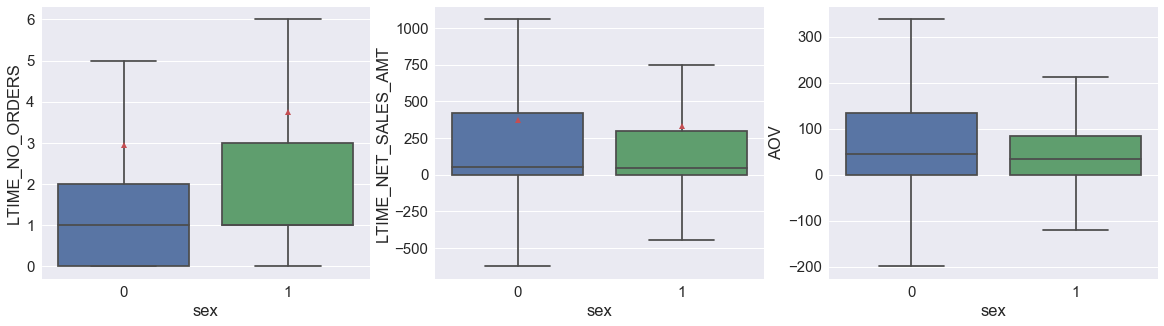

In [24]:
plot_value('sex')

**Age** <br>
The age distribution is skewed. Half of customers are 33 years old or younger. However, I hypothetize that older customers could be more valuable than young ones, with higher spend per order.

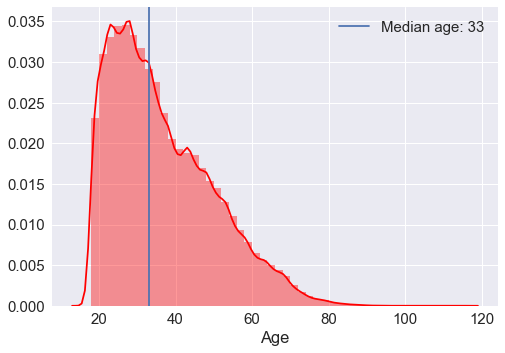

In [26]:
sns.distplot(df_customer.age, color='red')
plt.xlabel('Age')
median_age=np.percentile(df_customer.age, 50)
plt.axvline(median_age,label='Median age: {}'.format(int(median_age)))
plt.legend();

In [28]:
df_customer['age_categories'] = pd.qcut(df_customer['age'],3) #create bins to split customers into 3 approximately equal categories 

My theory about older customers bringing in more revenue does not seem to be based on reality, as neither net sales nor AOV are higher for customers older than 41. It seems that the company is failing to turn most customers over 41 into regular customers. The oldest 1/3 of customers come to the website and even make purchases, but most often stop after a few orders at maximum. 

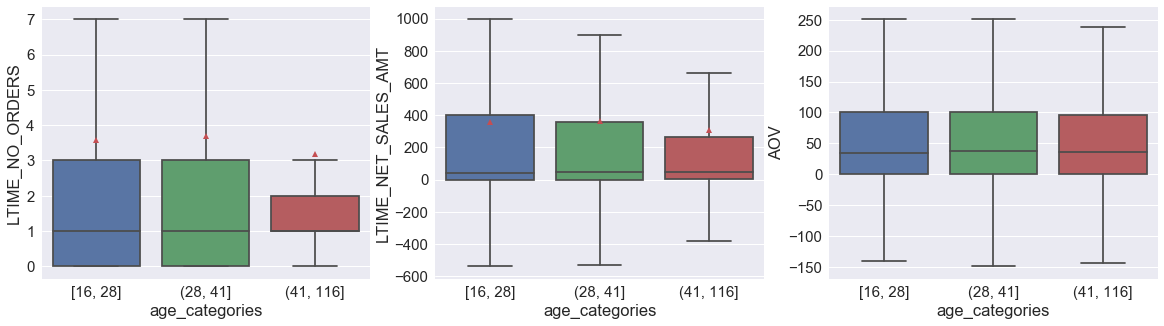

In [29]:
plot_value('age_categories')

In [97]:
df_order['Week_Ending']=pd.to_datetime(df_order['Week_Ending'],format='%d%b%Y')

### Order data: Account type and online device type

Order price differs depending on the device type and account type. It is highest for desktop and credit purchases. This could mean that despite the fact that customers use their phone for most purchases, shopping experience on desktop is still better than on mobile. Customers likely use their phone for quicker purchases and do not spend as much time browsing, I'd need website and mobile logs to validate this theory, though.  <br>
As for credit purchases, credit would it could just be that customers who order more expensive items are more likely to purchase them on credit.<br>

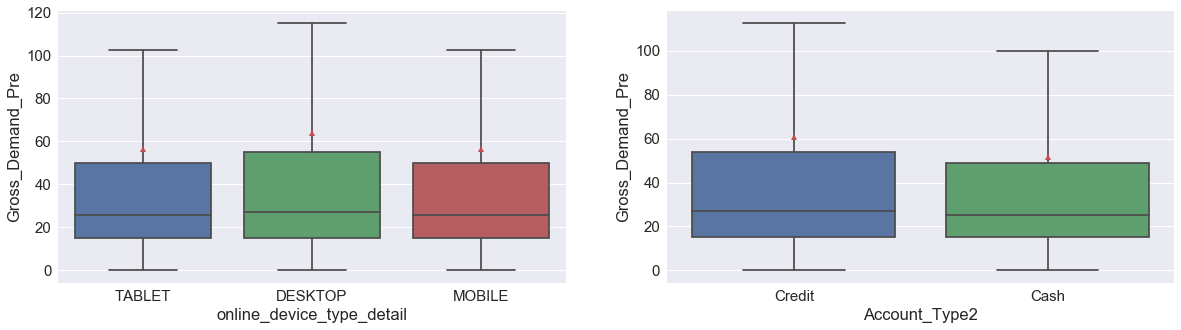

In [138]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=False)
sns.boxplot(x='online_device_type_detail',y='Gross_Demand_Pre',data=df_order,showmeans=True,showfliers=False,ax=axes[0])
sns.boxplot(x='Account_Type2',y='Gross_Demand_Pre',data=df_order,showmeans=True,showfliers=False,ax=axes[1])

### Order distribution

It seems that there are a lot of customers who bought once but never purchased again. Understanding why customers do not reorder after their first purchase could help the company come up with measures to turn those customers into repeat customers. Conversely, the top few customers contribute significantly to the bottom line. I'll  investigate further and perform a simple segmentation in the next section.

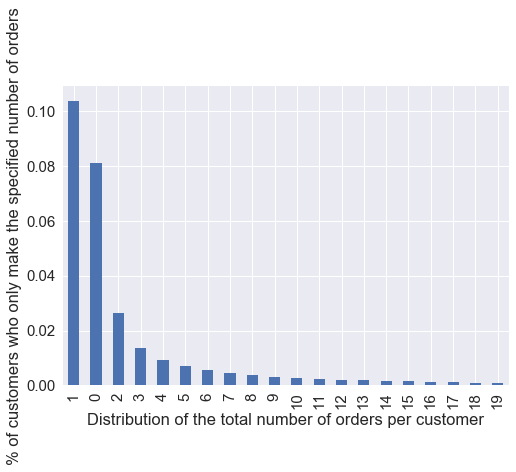

In [34]:
(df_customer['LTIME_NO_ORDERS'].value_counts()[:20]/df_customer['LTIME_NO_ORDERS'].sum()).plot.bar()
plt.xlabel('Distribution of the total number of orders per customer')
plt.ylabel('% of customers who only make the specified number of orders');

** Seasonality** <br>

The time series plot does not show anything unexpected. The number of orders is steadily growing in time. As expected, the biggest jump in demand is right before Christmas. Plotting other trends in time could be interesting (ie AOV or mobile purchases), however, I was unable to follow this lead due to limited time.

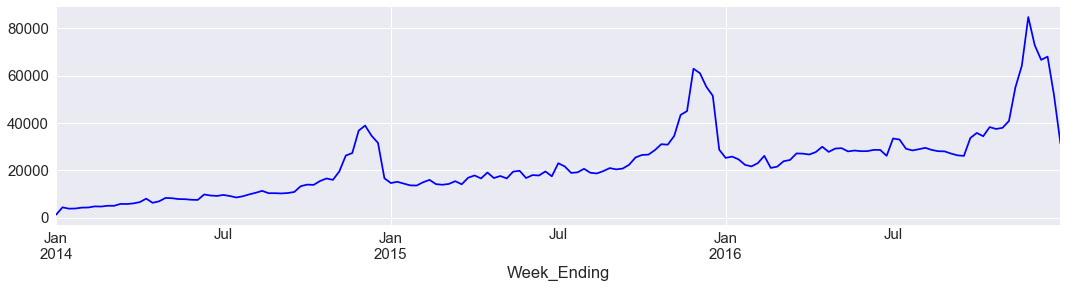

In [109]:
fig = plt.figure(figsize=(18,4))
df_order.groupby('Week_Ending')['Gross_Demand_Pre'].count().plot(kind='line',c='b', label="orders");

## Simple segmentation of active customers (RFM model)
<br>

I will segment existing clients based on:

- **Monetary value** - total net revenue
- **Lifetime number of orders**
- **Recency** - date of last purchase

These variables are frequently used in customer segmentation for marketing purposes. I’ll be using the k-means clustering technique to experiment with cluster assigment.

**Recency calculation** 
<br> I already have the first 2 values, the only missing is recency. I can calculate from the orders table by taking the date of the last order made by the customer.

In [51]:
df_order['Week_Ending']=pd.to_datetime(df_order['Week_Ending'],format='%d%b%Y') #change into datetime format

In [52]:
#get the date of the most recent order for each customer id
df_customer = df_customer.merge(df_order.groupby('identifier')['Week_Ending'].max().reset_index(), how='left', on='identifier')

In [53]:
df_customer_clustering=df_customer[df_customer['status_code']=='active'] #create a copy of DF with active customers only
df_customer_clustering.rename(columns={'Week_Ending':'last_date'},inplace=True) #rename column
df_customer_clustering.dropna(subset=['last_date'], inplace=True) #consider only customers with given last date
df_customer_clustering['recency'] = (df_customer_clustering.last_date.max()-df_customer_clustering.last_date).dt.days #calculate recency

In [300]:
df_customer_clustering[['LTIME_NET_SALES_AMT','LTIME_NO_ORDERS','recency']].head(2) #check values

,LTIME_NET_SALES_AMT,LTIME_NO_ORDERS,recency
0,604.42,5,7
2,512.94,5,28


Cutoff points I selected: <br>
**Recency**: recent customers: < 30 days, sleeping:< 120, lost >120 <br>
**Lifetime number of orders**: <=2: one-off customers, 2-5 repeat customers, >5 loyal customers        
**Monetary value**: <= 200: low value customers, < 1000 mid value customers, >1000: high value customers <br>

In [54]:
df_customer_clustering['recency_cluster'] = pd.cut(df_customer_clustering['recency'],[-1,30,120,10000],labels=['<30','30-120','>120'])
df_customer_clustering['value_cluster'] =  pd.cut(df_customer_clustering['LTIME_NET_SALES_AMT'],[-100000,200,1000,100000],labels=['<200','200-1000','>1000'])
df_customer_clustering['order_cluster']=pd.cut(df_customer_clustering['LTIME_NET_SALES_AMT'],[-100000,2,5,100000],labels=['1-2','3-5','>5'])

**Active loyal customers** <br>
These are loyal customers who have a high lifetime value.The company should take extra care of these customers and look out for signs they might become inactive (such as no recent website visit or purchase). Gaining feedback from this group of customers could further improve the experience for them. Furthermore, these are likely the customers who will promote the products when given a chance - it could test giving these customers special offers when they invite their friends. 

In [55]:
#Loyal customers who made purchases recently
df_customer_clustering[df_customer_clustering.order_cluster=='>5'][df_customer_clustering.recency_cluster=='<30'].mean()

identifier             254783.328101
open_to_buy_amt           588.910002
LTIME_NET_SALES_AMT      1102.432966
LTIME_NO_ORDERS            11.654777
LTIME_RETURNED_AMT        205.790862
AOV                       112.259158
sex                         0.689533
age                        35.642574
recency                    13.532874
dtype: float64

**One-off customers** <br>
These customers made one or two purchases and have not showed up anymore. I'd like to understand the reasons behind this - this is an opportunity for promotion or figuring out what went wrong. 

In [347]:
#Sleeping one-off customers who have not been active for a while - not likely to return
df_customer_clustering[df_customer_clustering.order_cluster=='1-2'][df_customer_clustering.recency_cluster=='>120'].mean()

identifier             257582.808929
open_to_buy_amt           460.560714
LTIME_NET_SALES_AMT        -4.225107
LTIME_NO_ORDERS             1.091071
LTIME_RETURNED_AMT         74.235429
sex                         0.792857
age                        37.798214
AOV                        -2.933136
recency                   175.050000
dtype: float64

In [56]:
#get the date of the most recent order for each customer id
df_customer = df_customer.merge(df_order.groupby('identifier')['Week_Ending'].max().reset_index(), how='left', on='identifier')

## K-means clustering solution

I will try to build customer segments using k-means clustering.  Unfortunately, based on the silhouette score,it does not seem like there are truly distinct groups. The results can stil be valuable. I will try to use 2 and 5 clusters and visualise the result.  

In [61]:
#k-means clustering requires scaling
from sklearn.preprocessing import StandardScaler
sca = StandardScaler() #initialize scaler with default values
data_sca=sca.fit_transform(df_customer_clustering[['LTIME_NET_SALES_AMT','LTIME_NO_ORDERS','recency']]) 

In [63]:
# Perform clustering for various k
from sklearn.cluster import KMeans
K = range(1,10)
KM = [sklearn.cluster.KMeans(n_clusters=k).fit(data_sca) for k in K]
centroids = [k.cluster_centers_ for k in KM]
labels = [KM.labels_ for KM in KM]

In [64]:
# Determine the silhouette score to see if I can determine the optimal number of clusters
k_coeff = {}
for k in range(1,9):
    sil_coeff = sklearn.metrics.silhouette_score(data_sca, labels[k], metric='euclidean',sample_size=10000)
    k_coeff[k]=sil_coeff

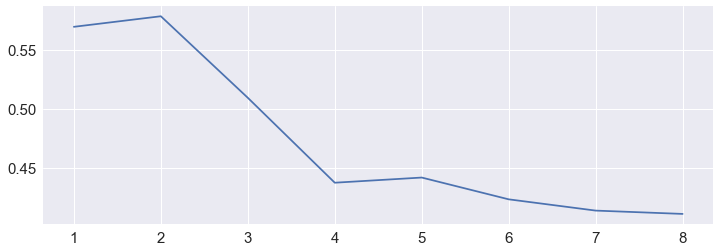

In [65]:
fig = plt.figure(figsize =(12,4)) # plot silhouette score 
ax = plt.axes()
plt.plot(list(k_coeff.keys()),list(k_coeff.values()))

I'll go for 2 and 5 clusters and visualise the result using PCA.

In [84]:
from sklearn.pipeline import Pipeline
pca = sklearn.decomposition.PCA(n_components=2) #decrease the number of dimensions from 3 to 2 to aid visualisation

In [85]:
def visualise_clusters(k,df):
    kmeans = KMeans(n_clusters=k) #initialize k means
    pipeline = Pipeline([ #scale before performing k-means clustering
        ('sca', sca),
        ('kmeans', kmeans)])
    df['cluster'] = pipeline.fit_predict(df[['AOV','LTIME_NO_ORDERS','recency']])
    # save cluster coordinates
    df_customer_clustering['x'] = pca.fit_transform(df_customer_clustering[['AOV','LTIME_NO_ORDERS','recency']])[:,0]
    df_customer_clustering['y'] = pca.fit_transform(df_customer_clustering[['AOV','LTIME_NO_ORDERS','recency']])[:,1]
    sns.lmplot('x', 'y',data=df,fit_reg=False,hue="cluster") # plot clusters
    plt.title('Customers Grouped by Cluster for k={}'.format(k)) # plot title
    plt.xlabel('PC1')
    plt.ylabel('PC2')

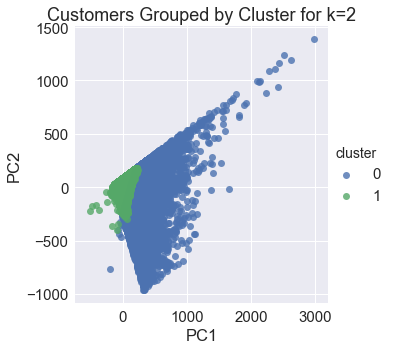

In [86]:
visualise_clusters(2,df_customer_clustering)

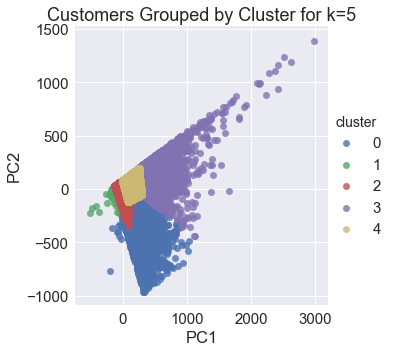

In [87]:
visualise_clusters(5,df_customer_clustering)

The solution with 5 clusters seems better for our analysis. 
Here are some of the most distinctive clusters:

Cluster 3:  Active and loyal customers with low AOV.

In [88]:
# cluster 3: high number of orders, low AOV, low recency and high sales. 
df_customer_clustering[df_customer_clustering['cluster']==3][['LTIME_NET_SALES_AMT','LTIME_NO_ORDERS','recency','AOV','sex','age']].mean()

LTIME_NET_SALES_AMT    934.981680
LTIME_NO_ORDERS          1.643718
recency                126.819525
AOV                    599.134720
sex                      0.438740
age                     37.117464
dtype: float64

Cluster 4: One-off customers who made expensive purchases. They made one or two purchases and have not been active since. Mostly men. 

In [89]:
# cluster 4: High sales, low number of orders, mid recency. Mostly men, higher than average age 
df_customer_clustering[df_customer_clustering['cluster']==4][['LTIME_NET_SALES_AMT','LTIME_NO_ORDERS','recency','AOV','sex','age']].mean()

LTIME_NET_SALES_AMT    1062.731661
LTIME_NO_ORDERS           5.183809
recency                  58.052379
AOV                     221.605457
sex                       0.546002
age                      35.469138
dtype: float64

## Decision tree
As a final step, I will use decision tree classification to show how the newly created clusters can be interpreted. I will use the cluster assignment as the dependent variable and see which variables predict cluster assigment best.

In [162]:
#I will create a dataset with customer characteristics and assigned clusters, I will need dummy variables because Scikit learn DT cannot handle categories
df_customer_clustering['year_signup'] = df_customer_clustering['date_start'].dt.year #add year of signup
df_customer_clustering= pd.concat([df_customer_clustering,pd.get_dummies(df_customer_clustering[['principal_brand','postcode_area','age_categories']])],axis=1); #add brand dummy

In [175]:
#df_customer_clustering.drop(['x','y'],inplace=True,axis=1)
df_customer_clustering_final = df_customer_clustering[df_customer_clustering.iloc[:,24:].columns.tolist()+['sex']]

In [176]:
df_customer_clustering_final.head(2)

,cluster,year_signup,principal_brand_LAI,principal_brand_LEX,postcode_area_AB,postcode_area_AL,postcode_area_B,postcode_area_BA,postcode_area_BB,postcode_area_BD,postcode_area_BH,postcode_area_BL,postcode_area_BN,postcode_area_BR,postcode_area_BS,postcode_area_BT,postcode_area_CA,postcode_area_CB,postcode_area_CF,postcode_area_CH,postcode_area_CM,postcode_area_CO,postcode_area_CR,postcode_area_CT,postcode_area_CV,postcode_area_CW,postcode_area_DA,postcode_area_DD,postcode_area_DE,postcode_area_DG,postcode_area_DH,postcode_area_DL,postcode_area_DN,postcode_area_DT,postcode_area_DY,postcode_area_E,postcode_area_EC,postcode_area_EH,postcode_area_EN,postcode_area_EX,postcode_area_FK,postcode_area_FY,postcode_area_G,postcode_area_GL,postcode_area_GU,postcode_area_GY,postcode_area_HA,postcode_area_HD,postcode_area_HG,postcode_area_HP,postcode_area_HR,postcode_area_HS,postcode_area_HU,postcode_area_HX,postcode_area_IG,postcode_area_IM,postcode_area_IP,postcode_area_IV,postcode_area_JE,postcode_area_KA,postcode_area_KT,postcode_area_KW,postcode_area_KY,postcode_area_L,postcode_area_LA,postcode_area_LD,postcode_area_LE,postcode_area_LL,postcode_area_LN,postcode_area_LS,postcode_area_LU,postcode_area_M,postcode_area_ME,postcode_area_MK,postcode_area_ML,postcode_area_N,postcode_area_NE,postcode_area_NG,postcode_area_NN,postcode_area_NP,postcode_area_NR,postcode_area_NW,postcode_area_OL,postcode_area_OX,postcode_area_PA,postcode_area_PE,postcode_area_PH,postcode_area_PL,postcode_area_PO,postcode_area_PR,postcode_area_RG,postcode_area_RH,postcode_area_RM,postcode_area_S,postcode_area_SA,postcode_area_SE,postcode_area_SG,postcode_area_SK,postcode_area_SL,postcode_area_SM,postcode_area_SN,postcode_area_SO,postcode_area_SP,postcode_area_SR,postcode_area_SS,postcode_area_ST,postcode_area_SW,postcode_area_SY,postcode_area_TA,postcode_area_TD,postcode_area_TF,postcode_area_TN,postcode_area_TQ,postcode_area_TR,postcode_area_TS,postcode_area_TW,postcode_area_UB,postcode_area_W,postcode_area_WA,postcode_area_WC,postcode_area_WD,postcode_area_WF,postcode_area_WN,postcode_area_WR,postcode_area_WS,postcode_area_WV,postcode_area_YO,postcode_area_ZE,"age_categories_(28, 41]","age_categories_(41, 116]","age_categories_[16, 28]",sex
0,1,2016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,2016,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [177]:
# simple decision tree using cluster as predicted variable
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree.fit(df_customer_clustering_final.iloc[:,1:], df_customer_clustering_final['cluster'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

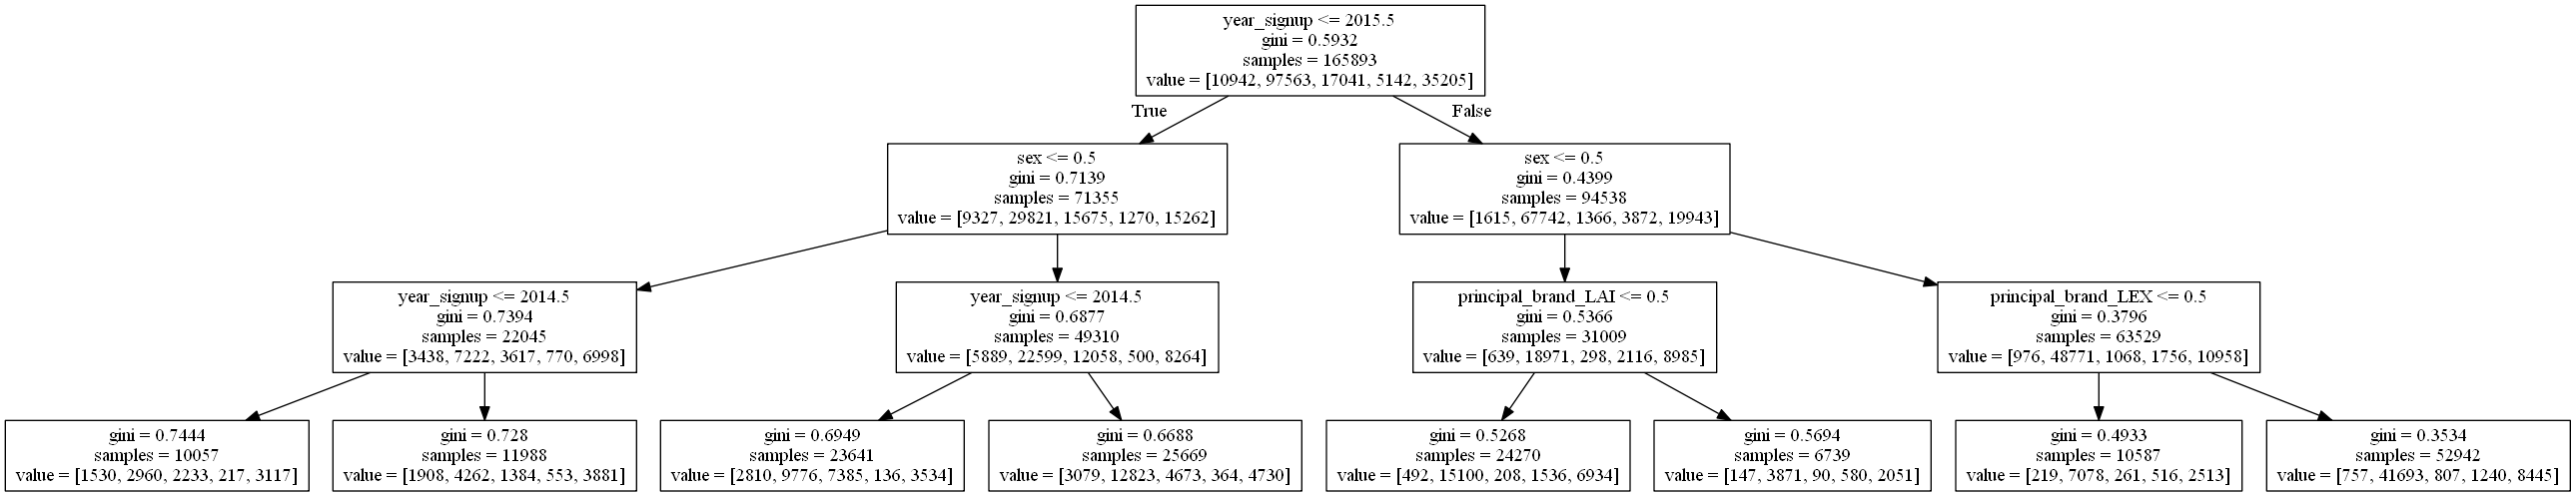

In [178]:
import os
from sklearn import tree
dotfile = open(r'C:\Users\micakova\Experiments\Pokusy\Search\tree_SD.dot', 'w')
tree.export_graphviz(dtree, out_file = dotfile, feature_names = df_customer_clustering_final.iloc[:,1:].columns.tolist())
dotfile.close()
import subprocess
subprocess.call(['dot', '-Tpng','-O',r'C:\Users\micakova\Experiments\Pokusy\Search\tree_SD.dot'])
import subprocess
from IPython.display import Image
Image(filename=r'C:\Users\micakova\Experiments\Pokusy\Search\tree_SD.dot.png')

It seems that the following features are valuable for defining segments: 
- Year of signup - older customers are have already spent a lot of money with the company and we should focus on retaining them
- Sex - men spend more than women 
- Principal brand


Other ideas for analysis: 
- Prediction of whether customer would default or not
- Predicting that customer would churn after a few months
- Predicting if a customer is going to become loyal